## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint 
import scipy
import seaborn as sns
import pandas as pd
import csv
import os

## Files

In [2]:
spike_dataset = "M1F" # edit as necessary
r2_dir = '../Results/' # Where R2 results are stored
cycle_path = "../spikesByCycle/" # Where spikesByCycle results are stored

In [3]:
files = next(os.walk(r2_dir))[2]
files = [f for f in files if spike_dataset in f and 'Br' not in f]

## Organize Data

In [4]:
dataset = ["RyCon", "RyNb", "YeCon", "YeNb"]
marker_regions = ['Anterior', 'Intermediate', 'Posterior', 'Superficial', 'Deep']
xyz = ['X', 'Y', 'Z']

In [5]:
raw_data = defaultdict(dict)
for f in files:
    curr_file = pd.read_csv(r2_dir + '/' + f)
    name = f.split('.')[0]

    column_names = list(curr_file.columns[1:])
    r2s = {cn.strip() : float(curr_file[cn].values) for cn in column_names}
    for d in dataset:
        if d in name:
            region = name.split('_')[2]
            raw_data[d][region] = r2s

In [6]:
def XYZ(markers):
    data = {
        'X': np.asarray([markers[i] for i in range(0, len(markers), 3)], dtype=float),
        'Y': np.asarray([markers[i + 1] for i in range(0, len(markers), 3)], dtype=float),
        'Z': np.asarray([markers[i + 2] for i in range(0, len(markers), 3)], dtype=float),
    }
    return data

def cat_XYZ(*args):
    data = {
        'X': np.concatenate(([arg['X'] for arg in args])).astype(float),
        'Y': np.concatenate(([arg['Y'] for arg in args])).astype(float),
        'Z': np.concatenate(([arg['Z'] for arg in args])).astype(float),
    }
    return data

region_xyz = defaultdict(dict)
for d in dataset:
    for mr in marker_regions:
        values = list(raw_data[d][mr].values())
        region_xyz[d][mr] = XYZ(values)

data_xyz = {}
for d in dataset:
    relevant = list(region_xyz[d].values())
    data_xyz[d] = cat_XYZ(*relevant)

## Heat Map

In [7]:
def get_frame(regions, features, data):
    feature = []
    region = []
    values = []
    for r in regions:
        for i in range(3):
            region.append(r)
        feature.append(features[0])
        feature.append(features[1])
        feature.append(features[2])
    for d in data:
        values.append(np.mean(d['X']))
        values.append(np.mean(d['Y']))
        values.append(np.mean(d['Z']))
    dict = {
        'Axis': feature,
        'Region': region,
        'Values': values
    }

    return pd.DataFrame(dict)

In [8]:
def heatmap(frame_c, frame_nb, title):
    heatmap_c = frame_c.pivot(columns='Axis',index='Region', values='Values')
    heatmap_nb = frame_nb.pivot(columns='Axis',index='Region', values='Values')

    plt.figure(figsize=(8, 4))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.title('Control')
    sns.heatmap(heatmap_c, vmin = 0, vmax = 1, annot=True, cmap='inferno')
    plt.subplot(1, 2, 2)
    plt.title('Nerve Block')
    sns.heatmap(heatmap_nb, vmin = 0, vmax = 1, annot=True, cmap='inferno')
    plt.show()

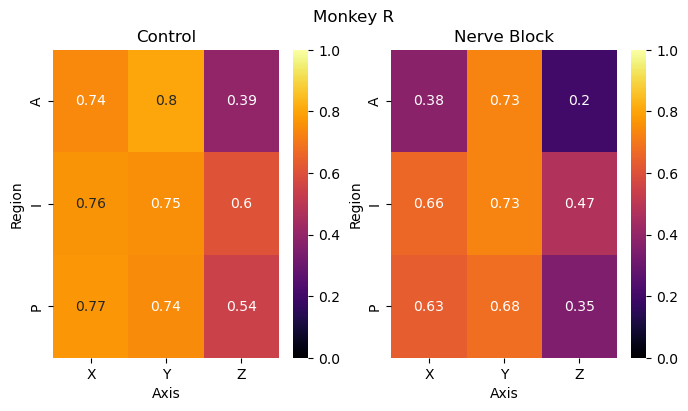

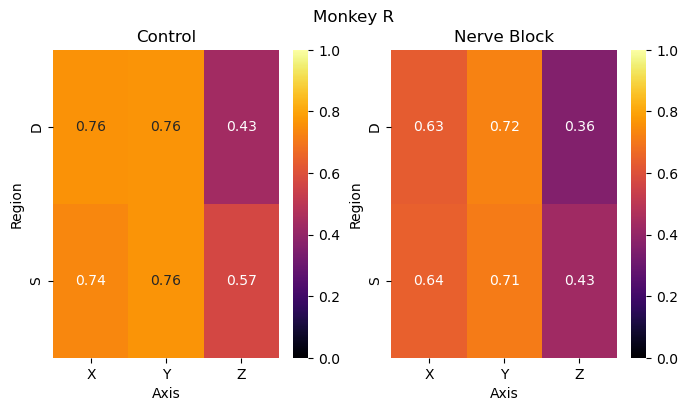

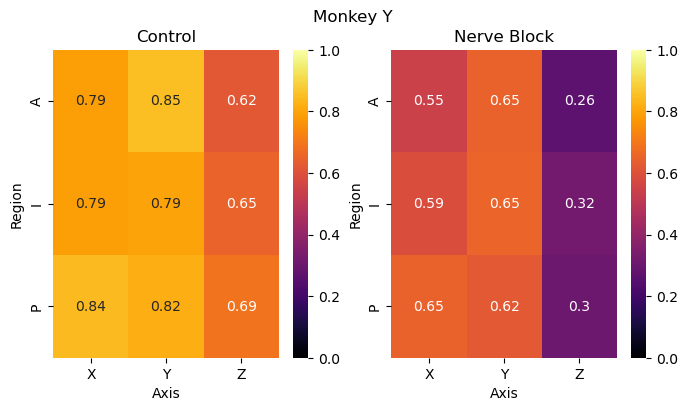

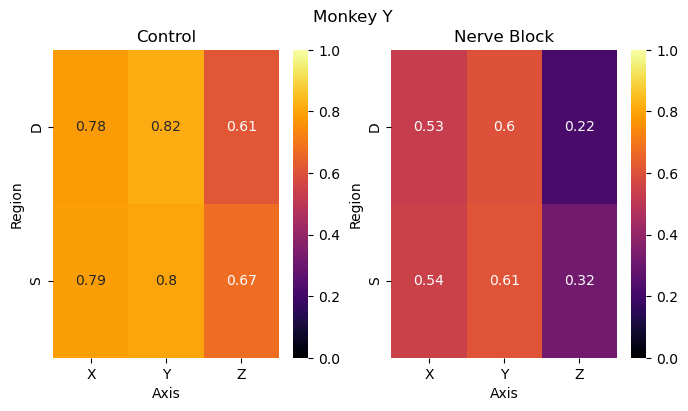

In [9]:
frames = {}
region = ['A', 'I', 'P']
depth = ['S', 'D']

for d in dataset:
    frames[d + ' Region'] = get_frame(region, xyz, [region_xyz[d]['Anterior'], region_xyz[d]['Intermediate'], region_xyz[d]['Posterior']])
    frames[d + ' Depth'] = get_frame(depth, xyz, [region_xyz[d]['Superficial'], region_xyz[d]['Deep']])

heatmap(frames['RyCon Region'], frames['RyNb Region'], 'Monkey R')
heatmap(frames['RyCon Depth'], frames['RyNb Depth'], 'Monkey R')
heatmap(frames['YeCon Region'], frames['YeNb Region'], 'Monkey Y')
heatmap(frames['YeCon Depth'], frames['YeNb Depth'], 'Monkey Y')

## Spike Histogram

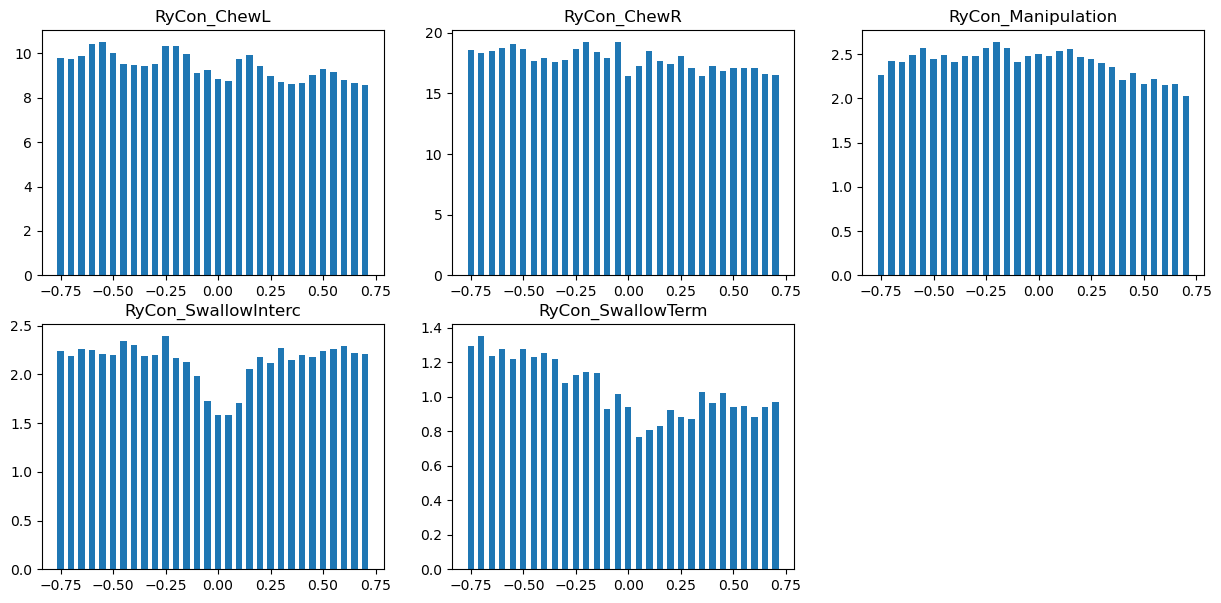

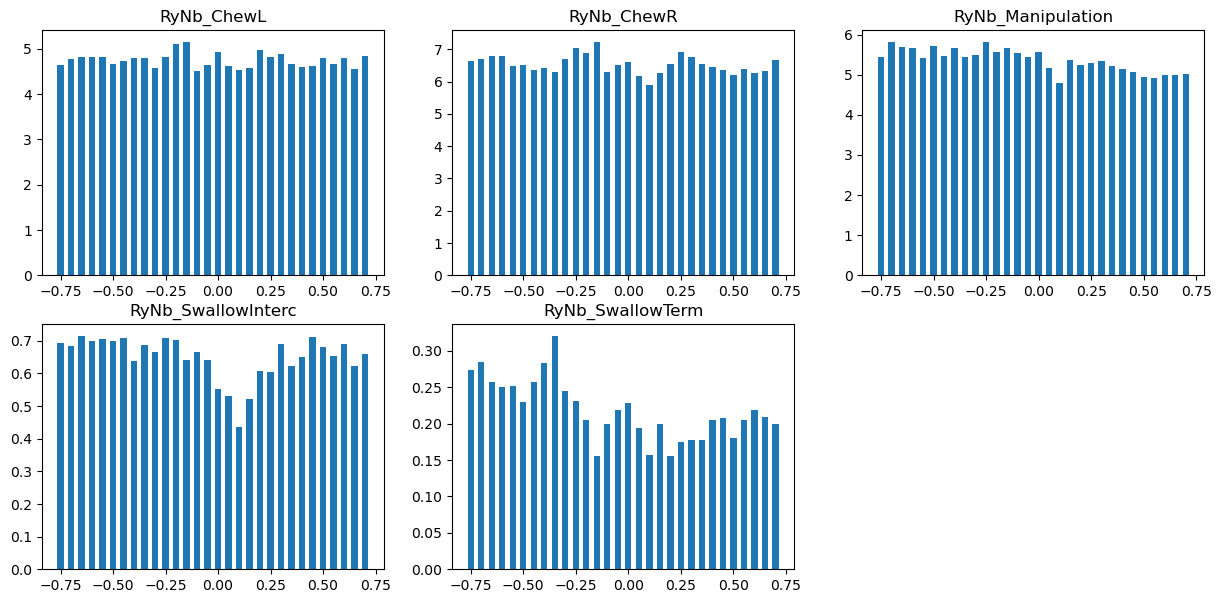

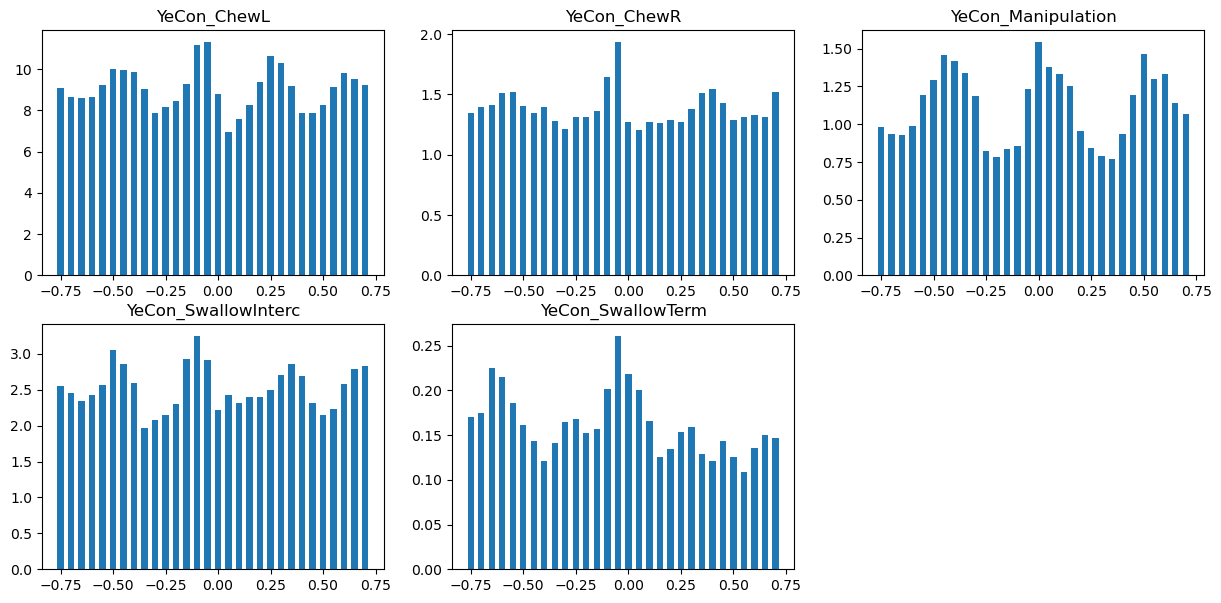

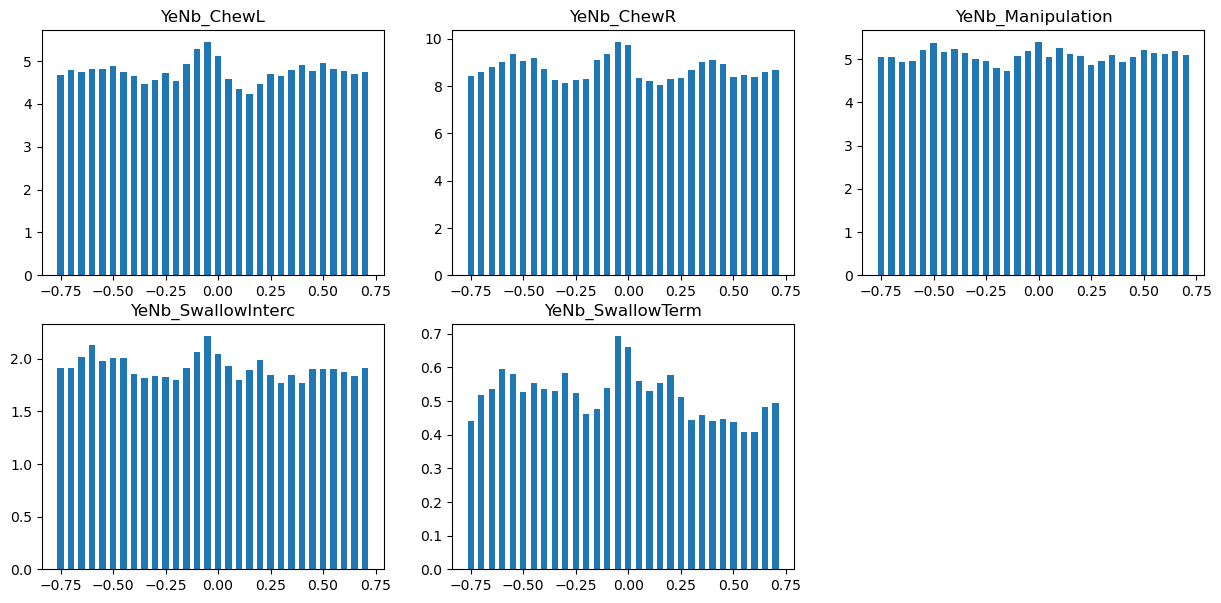

In [10]:
cycles = ["ChewL", "ChewR", "Manipulation", "SwallowInterc", "SwallowTerm"]

def test_cycle(data, cycle):
    if data["cycleType"] != cycle.lower():
        print("Expected: ", cycle)
        print("Real: ", data["cycleType"])
    return

for d_i, d in enumerate(dataset):
    plt.figure(figsize=(15, 7))
    for c_i, c in enumerate(cycles):
        cycle_data = scipy.io.loadmat(cycle_path + d + "_" + c)
        test_cycle(cycle_data, c)
        
        input = None
        neurons = [str(s).split()[1] for s in cycle_data["snrs"][spike_dataset.lower()][0, 0]]
        num_neurons = len(neurons)
        for i, neuron in enumerate(neurons):
            neuron_spikes = cycle_data["spikesByGapeCycle"][spike_dataset.lower()][0, 0][neuron]
            for j in range(neuron_spikes.shape[1]):
                extracted = np.squeeze(neuron_spikes[0, j][0, 0][0], axis=1)
                input = extracted if i == 0 and j == 0 else np.concatenate((input, extracted))
        
        plt.subplot(2, 3, c_i + 1)
        plt.title(d + "_" + c)
        y, x = np.histogram(input, bins=30)
        plt.bar(x[:-1], y / (num_neurons * 20), width=0.03)
    plt.show()  

## Percent Decrease (Post-Nerve Block)

In [11]:
def avg_pctdec(c, nb):
    diff = np.subtract(c, nb)
    div = diff / c
    return np.mean(div) * 100

def plot_pctdec(rc, rnb, yc, ynb):
    colors = ['blue', 'orange', 'green']
    rocky = []
    yosemite = []
    for i in range(len(xyz)):
        rocky.append(avg_pctdec(rc[xyz[i]], rnb[xyz[i]]))
        yosemite.append(avg_pctdec(yc[xyz[i]], ynb[xyz[i]]))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Monkey R')
    plt.ylabel('Average Decoding Performance Degradation')
    plt.ylim(0, 100)
    plt.bar(xyz, rocky, color=colors)

    plt.subplot(1, 2, 2)
    plt.title('Monkey Y')
    plt.ylim(0, 100)
    plt.bar(xyz, yosemite, color=colors)

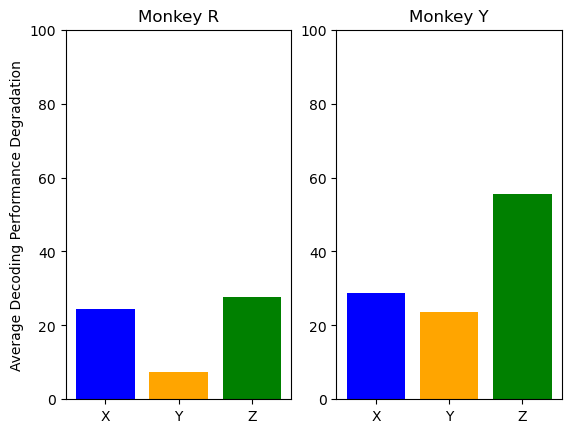

In [12]:
plot_pctdec(*[data_xyz[d] for d in dataset])

## Statistical Analysis

In [13]:
def print_stats(title, *datasets):
    if len(datasets) > 2:
        stat, p = scipy.stats.kruskal(*datasets)
    else:
        stat, p = scipy.stats.mannwhitneyu(*datasets)
    mult = ''
    if p < 0.05 and len(datasets) > 2:
        mult = scipy.stats.tukey_hsd(*datasets)
    elif p < 0.05:
        mult = 'Significant'

    print(title)
    print()
    print('H Statistic: ' + str(stat))
    print('P-Value: ' + str(p))
    if mult != '':
        print()
        print(mult)
    print()
    return float(stat)

### Control vs. Nerve Block

In [14]:
for i in range(len(xyz)):
    print_stats('Rocky ' + xyz[i], data_xyz['RyCon'][xyz[i]], data_xyz['RyNb'][xyz[i]])

for i in range(len(xyz)):
    print_stats('Yosemite ' + xyz[i], data_xyz['YeCon'][xyz[i]], data_xyz['YeNb'][xyz[i]])

Rocky X

H Statistic: 625.0
P-Value: 1.4156562248495537e-09

Significant

Rocky Y

H Statistic: 478.0
P-Value: 0.001367281930175315

Significant

Rocky Z

H Statistic: 461.0
P-Value: 0.0040837137563017965

Significant

Yosemite X

H Statistic: 625.0
P-Value: 1.4156562248495537e-09

Significant

Yosemite Y

H Statistic: 619.0
P-Value: 2.89803473430279e-09

Significant

Yosemite Z

H Statistic: 619.0
P-Value: 2.89803473430279e-09

Significant



### Across Regions

In [15]:
print('Anterior vs. Intermediate vs. Posterior')
print()
for d in dataset:
    print(d)
    print()
    for i in range(len(xyz)):
        print_stats(xyz[i], region_xyz[d]['Anterior'][xyz[i]], region_xyz[d]['Intermediate'][xyz[i]], region_xyz[d]['Posterior'][xyz[i]])

Anterior vs. Intermediate vs. Posterior

RyCon

X

H Statistic: 4.176785714285714
P-Value: 0.12388607853616812

Y

H Statistic: 6.50714285714286
P-Value: 0.038635975508402316

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.050     0.118    -0.011     0.111
 (0 - 2)      0.059     0.056    -0.002     0.120
 (1 - 0)     -0.050     0.118    -0.111     0.011
 (1 - 2)      0.010     0.922    -0.059     0.079
 (2 - 0)     -0.059     0.056    -0.120     0.002
 (2 - 1)     -0.010     0.922    -0.079     0.059


Z

H Statistic: 5.357142857142861
P-Value: 0.06866117151308486

RyNb

X

H Statistic: 11.400000000000006
P-Value: 0.003345965457471265

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.285     0.000    -0.408    -0.163
 (0 - 2)     -0.258     0.000    -0.380    -0.136
 (1 - 0)      0.285     0.000     0.163     0.408


In [16]:
print('Superficial vs. Deep')
print()
for d in dataset:
    print(d)
    print()
    for i in range(len(xyz)):
        print_stats(xyz[i], region_xyz[d]['Superficial'][xyz[i]], region_xyz[d]['Deep'][xyz[i]])

Superficial vs. Deep

RyCon

X

H Statistic: 7.0
P-Value: 0.35238095238095235

Y

H Statistic: 13.0
P-Value: 0.9142857142857143

Z

H Statistic: 18.0
P-Value: 0.2571428571428571

RyNb

X

H Statistic: 15.0
P-Value: 0.6095238095238095

Y

H Statistic: 10.0
P-Value: 0.7619047619047619

Z

H Statistic: 15.0
P-Value: 0.6095238095238095

YeCon

X

H Statistic: 16.0
P-Value: 0.47619047619047616

Y

H Statistic: 9.0
P-Value: 0.6095238095238095

Z

H Statistic: 16.0
P-Value: 0.47619047619047616

YeNb

X

H Statistic: 15.0
P-Value: 0.6095238095238095

Y

H Statistic: 13.0
P-Value: 0.9142857142857143

Z

H Statistic: 19.0
P-Value: 0.17142857142857143



### Across Axes of Motion

In [17]:
print('X vs. Y vs. Z')
print()
for d in dataset:
    print(d)
    print()
    print_stats('Anterior', region_xyz[d]['Anterior']['X'], region_xyz[d]['Anterior']['Y'], region_xyz[d]['Anterior']['Z'])
    print_stats('Intermediate', region_xyz[d]['Intermediate']['X'], region_xyz[d]['Intermediate']['Y'], region_xyz[d]['Intermediate']['Z'])
    print_stats('Posterior', region_xyz[d]['Posterior']['X'], region_xyz[d]['Posterior']['Y'], region_xyz[d]['Posterior']['Z'])

X vs. Y vs. Z

RyCon

Anterior

H Statistic: 17.461966604823758
P-Value: 0.00016150357127116938

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.065     0.419    -0.193     0.063
 (0 - 2)      0.344     0.000     0.216     0.472
 (1 - 0)      0.065     0.419    -0.063     0.193
 (1 - 2)      0.409     0.000     0.280     0.537
 (2 - 0)     -0.344     0.000    -0.472    -0.216
 (2 - 1)     -0.409     0.000    -0.537    -0.280


Intermediate

H Statistic: 3.2307692307692335
P-Value: 0.19881418873807402

Posterior

H Statistic: 7.384615384615387
P-Value: 0.024914440787632705

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.026     0.662    -0.055     0.107
 (0 - 2)      0.226     0.000     0.145     0.307
 (1 - 0)     -0.026     0.662    -0.107     0.055
 (1 - 2)      0.200     0.000     0.119     0.281
 (2 - 0)     -0.

In [18]:
print('X vs. Y vs. Z')
print()
for d in dataset:
    print(d)
    print()
    print_stats('Superficial', region_xyz[d]['Superficial']['X'], region_xyz[d]['Superficial']['Y'], region_xyz[d]['Superficial']['Z'])
    print_stats('Deep', region_xyz[d]['Deep']['X'], region_xyz[d]['Deep']['Y'], region_xyz[d]['Deep']['Z'])

X vs. Y vs. Z

RyCon

Superficial

H Statistic: 6.538011695906434
P-Value: 0.0380442300302711

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.028     0.897    -0.194     0.137
 (0 - 2)      0.166     0.049     0.001     0.331
 (1 - 0)      0.028     0.897    -0.137     0.194
 (1 - 2)      0.194     0.021     0.029     0.360
 (2 - 0)     -0.166     0.049    -0.331    -0.001
 (2 - 1)     -0.194     0.021    -0.360    -0.029


Deep

H Statistic: 7.423076923076927
P-Value: 0.024439894496176142

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.003     0.999    -0.169     0.163
 (0 - 2)      0.327     0.001     0.161     0.492
 (1 - 0)      0.003     0.999    -0.163     0.169
 (1 - 2)      0.330     0.001     0.164     0.495
 (2 - 0)     -0.327     0.001    -0.492    -0.161
 (2 - 1)     -0.330     0.001    -0.495    -0.164